# Ejercicio 4 - Consigna
Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizar el dataset para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro. Particularmente, vamos a tratar este problema como una clasificación binaria donde queremos averiguar si el cliente va a gastar mucha plata (más de 9000) o poca plata (menos de 9000).

- a)	Entrenar un modelo de deep learning que no utilice embeddings.
- b)	Entrenar un modelo de deep learning que utilice embeddings tanto para los productos como los usuarios. Realizar el mapeo de identificador de producto y usuarios a indices antes de separar el dataset en training, validation y testing.
- c)	Compare el score de cada modelo y comente lo necesario.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (a)

## Cargamos el dataset

In [62]:
df = pd.read_csv("dataset_black_sales.csv")

## Analisis exploratorio

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [64]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [65]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

Valores Nulos encontrados para las categorías secundarias y terciarias. Dado que no tenemos más información sobre a qué referencia hacen, las pondremos en 0 ya que actualmente no se utiliza ese valor (ver siguientes secciones).

In [66]:
df.fillna(0,inplace=True)  # reemplazamos los N/A por 0

In [406]:
df.groupby('Product_ID').describe()['Purchase']
# Para cada producto, la compra final que se hizo varia. Esto

,count,mean,std,min,25%,50%,75%,max
Product_ID,,,,,,,,
P00000142,1152.0,11143.642361,2305.175261,2725.0,10591.75,10927.0,13379.25,13716.0
P00000242,376.0,10551.851064,3170.603417,3214.0,9588.00,10023.0,13029.00,16503.0
P00000342,244.0,5313.422131,1824.925693,1727.0,3702.75,5287.0,6928.75,8896.0
P00000442,92.0,4795.358696,1664.088125,1764.0,3599.75,5194.0,5394.75,8891.0
P00000542,149.0,5417.530201,1724.458154,1730.0,3750.00,5376.0,6955.00,8903.0
...,...,...,...,...,...,...,...,...
P0099442,200.0,14351.915000,3689.310564,4093.0,12189.00,16007.5,16406.50,20684.0
P0099642,13.0,6439.230769,2108.412442,3903.0,4222.00,5972.0,7862.00,10056.0
P0099742,126.0,7872.603175,2921.579042,2670.0,5626.00,8183.5,10636.75,13661.0


In [67]:
# Veamos la cantidad de valores únicos de algunos otros features
for i in ['User_ID', 'Product_ID']:
    print(i + ' unique values: ' + str(len(df[i].unique())))
# Veamos los valores unicos de algunos de los features
for i in ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']:
    print(i + ' values: ' + str(df[i].unique()) + ' - Total: ' + str(len(df[i].unique())))


User_ID unique values: 5891
Product_ID unique values: 3631
Gender values: ['F' 'M'] - Total: 2
Age values: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25'] - Total: 7
Occupation values: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6] - Total: 21
City_Category values: ['A' 'C' 'B'] - Total: 3
Stay_In_Current_City_Years values: ['2' '4+' '3' '1' '0'] - Total: 5
Marital_Status values: [0 1] - Total: 2
Product_Category_1 values: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19] - Total: 20
Product_Category_2 values: [ 0.  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.] - Total: 18
Product_Category_3 values: [ 0. 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.] - Total: 16


Text(721.8320000000001, 0.5, 'Product_Category_3')

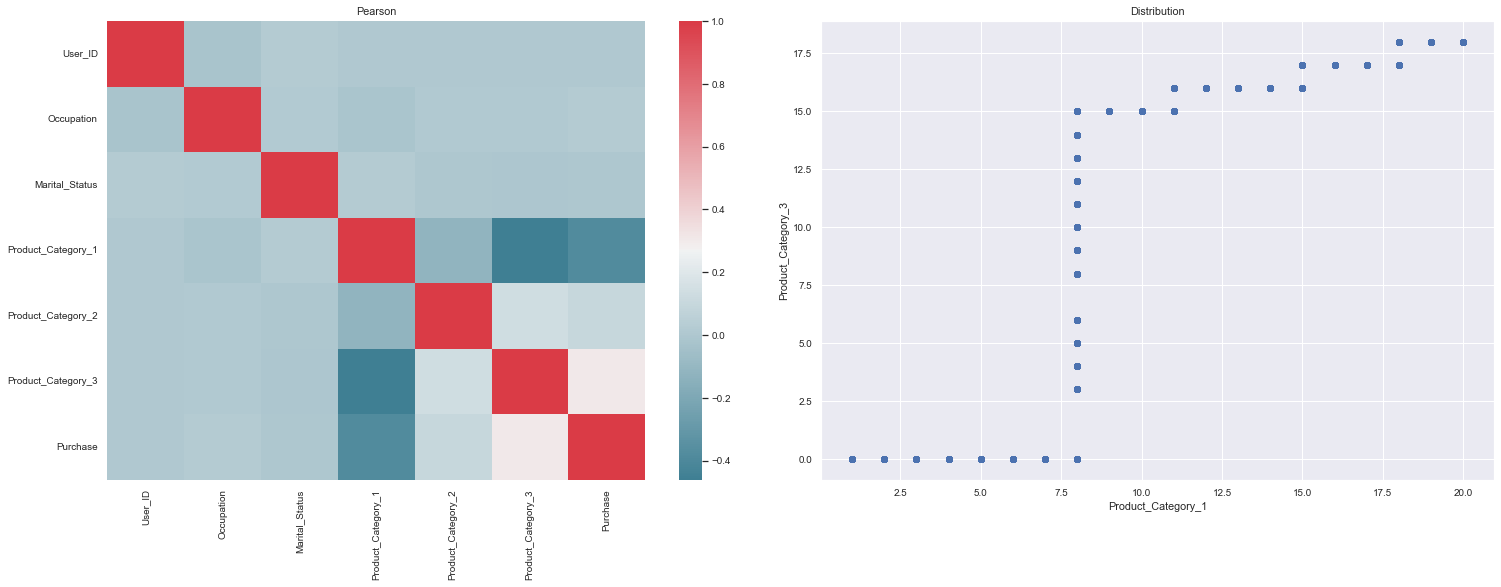

In [68]:
import seaborn as sns

corr_spearman = df.corr(method='spearman')

fig, axes = plt.subplots(1,2,figsize=(20,7), )
plt.tight_layout()

axes[0].set_title("Pearson")
sns.heatmap(corr_spearman, cmap=sns.diverging_palette(220,10,as_cmap=True),fmt=".2f",ax=axes[0])
sns.set(font_scale=0.9)

axes[1].set_title("Distribution")
plt.scatter(np.sort(df['Product_Category_1']), np.sort(df['Product_Category_3']))
plt.xlabel('Product_Category_1')
plt.ylabel('Product_Category_3')

Correlación: el análisis de correlación de Spearman no muestra una gran correlación entre los features. La mayor correlación se da entre las categorías 1 y 3, llegando a ser de 0.5. Sin embargo, un análisis de las distribuciones de una contra la otra muestra que la categoría 3 nos aporta gran cantidad de información que la 1 no tiene (notar alrededor del 8 de categoría 1). Por lo tanto , no podemos reducir dimensionalidad sin perder información significativa que puede ser útil para el problema final.

In [69]:
# Veamos la relación de otras variables con la salida
# plt.figure(figsize=(12,12))
# df.plot(x='Age', y='Purchase', figsize=(12,12))
df['y'] = df['Purchase'] >= 9000    
# df.hist(column='Purchase', by='Age', figsize=(12,12))
df.groupby('y').nunique()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
y,,,,,,,,,,,,
False,5890,3559,2,7,21,3,5,2,20,18,16,7304
True,5874,2031,2,7,21,3,5,2,12,17,16,10801


### Analizamos las variables categóricas respecto a la variable de salida

#### Stay_In_Current_City_Years

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

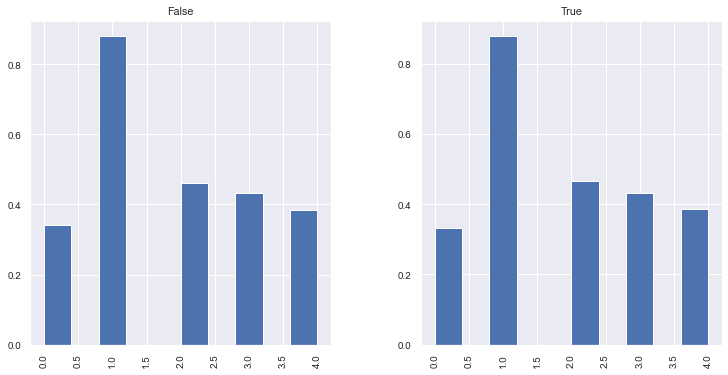

In [130]:
df_temp = df.copy()
df_temp['Stay_In_Current_City_Years'].replace(['2', '4+', '3', '1', '0'], [2, 4, 3, 1, 0], inplace=True)
df_temp.hist(column='Stay_In_Current_City_Years', by='y', figsize=(12,6), density=1, sharex=True) # density=1 para normalizar entre ambos histogramas (ya sabemos que va a haber menos gente que compra > 9000)

# Del gráfico se puede ver que la distribución es prácticamente la misma para y=0 e y=1, por lo que esta variable no nos aporta tanta información

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


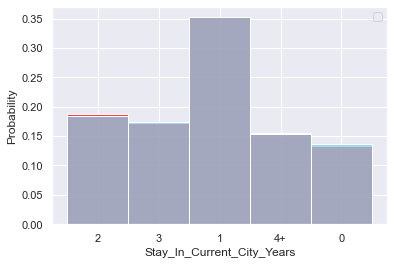

In [169]:
sns.set(style="darkgrid")
sns.histplot(data=df[df['y']==True], x="Stay_In_Current_City_Years", color="red", label="Sepal Width",  stat = "probability")
sns.histplot(data=df[df['y']==False], x="Stay_In_Current_City_Years", color="skyblue", label="Sepal Length",  stat = "probability")
plt.legend() 
plt.show()

#### City_Category

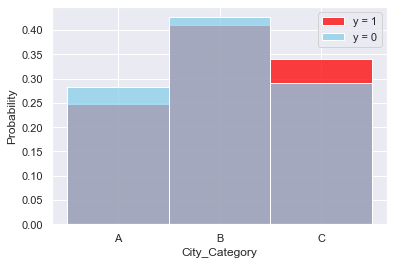

In [181]:
sns.set(style="darkgrid")
sns.histplot(data=df[df['y']==True], x="City_Category", color="red", label="y = 1",  stat = "probability")
sns.histplot(data=df[df['y']==False], x="City_Category", color="skyblue", label="y = 0",  stat = "probability")
plt.legend() 
plt.show()
# La categoría de la ciudad sí influye en la salida

#### Marital_Status

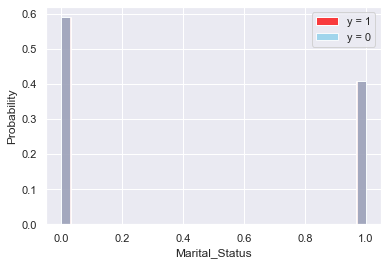

In [182]:
# df.hist(column='', by='y', density=1)
sns.set(style="darkgrid")
sns.histplot(data=df[df['y']==True], x="Marital_Status", color="red", label="y = 1",  stat = "probability")
sns.histplot(data=df[df['y']==False], x="Marital_Status", color="skyblue", label="y = 0",  stat = "probability")
plt.legend() 
plt.show()

# El estado civil no afecta en la salida

#### Occupation

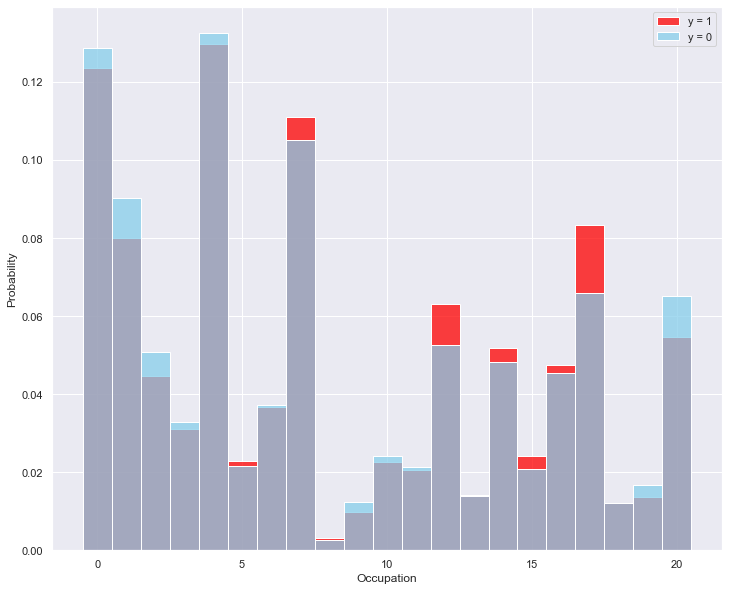

In [210]:
sns.set(style="darkgrid")
plt.figure(figsize=(12,10))
sns.histplot(data=df[df['y']==True], x="Occupation", color="red", label="y = 1",  stat = "probability", discrete=True)
sns.histplot(data=df[df['y']==False], x="Occupation", color="skyblue", label="y = 0",  stat = "probability", discrete=True)
plt.legend() 
plt.show()
# Para la ocupación, se empieza a ver impacto en la salida. Se nota que, para las ocupaciones menos frecuentes (menos muestras), no existe tanta 
# diferencia a la hora de predecir la variable de salida. Esto nos permite agrupar las N categorias con menor frecuencia en una sola, 
# ahorrando dimensiones finales.

# Occupation values: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6] - Total: 21
# df_temp['Occupation'] = df_temp['Occupation'].apply(lambda x: 0 if x<7 else (1 if x < 14 else 2))

#### Age

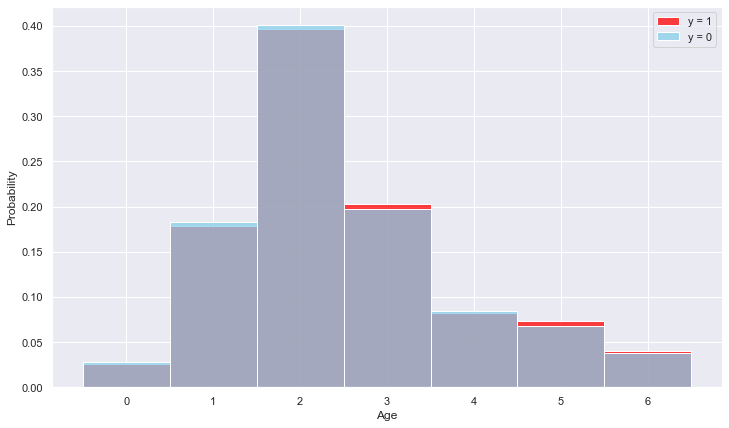

<Figure size 360x360 with 0 Axes>

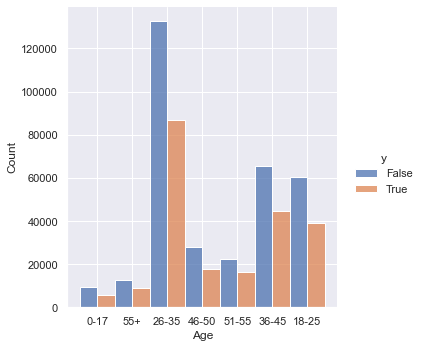

In [218]:
# Age values: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25'] - Total: 7
df_temp = df.copy()
# df_temp['Age'].replace(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'], [0, 55, 26, 46, 51, 36, 18], inplace=True)
df_temp['Age'].replace(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'], [0, 6, 2, 4, 5, 3, 1], inplace=True)
plt.figure(figsize=(12,7))
sns.set(style="darkgrid")
sns.histplot(data=df_temp[df_temp['y']==True], x="Age", color="red", label="y = 1",  stat = "probability", discrete=True)
sns.histplot(data=df_temp[df_temp['y']==False], x="Age", color="skyblue", label="y = 0",  stat = "probability", discrete=True)
plt.legend() 
plt.figure(figsize=(5,5))
df_temp = df.copy()
sns.displot(df, x="Age", hue="y", multiple="dodge")
# Se ve una leve tendencia de las mayores edades a hacer compras grandes

#### Gender

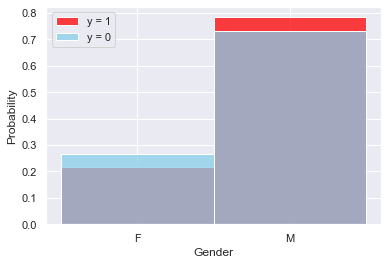

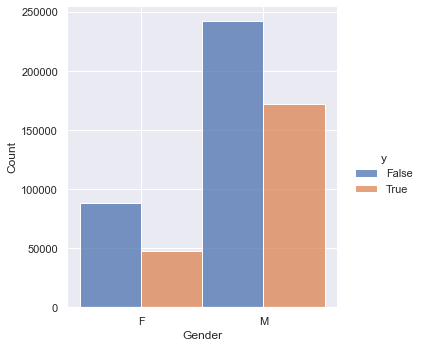

In [223]:
sns.set(style="darkgrid")
sns.histplot(data=df[df['y']==True], x="Gender", color="red", label="y = 1",  stat = "probability")
sns.histplot(data=df[df['y']==False], x="Gender", color="skyblue", label="y = 0",  stat = "probability")
plt.legend() 
plt.show()
sns.displot(df, x="Gender", hue="y", multiple="dodge")
# El gender nos da cierta información. Los hombres son más probables a hacer la compra más cara.

## Reducción de dimensionalidad y Codificación
Según las conclusiones obtenidas en la exploración del dataset, y dado que en este punto de la consigna no se deben utilizar embeddings, procedemos a quitar las variables categóricas que tienen menor correlación con la variable de salida, ya que incluirlas durante el entrenamiento incurriría en un aumento significativo del dataset al hacer One-Hot Encoding o similar.

Dado que no vamos a usar embeddings, el User_ID y el Product_ID son variables categóricas que se hace dificl codificar sin aumentar en gran cantidad las dimensiones.

In [241]:
dfa = df.copy()
dfa = dfa.drop(['User_ID', 'Product_ID', 'Product_Category_2', 'Product_Category_3', 'Marital_Status', 'Stay_In_Current_City_Years', 'Purchase'], axis=1)
dfa.head()

,Gender,Age,Occupation,City_Category,Product_Category_1,y
0,F,0-17,10,A,3,False
1,F,0-17,10,A,1,True
2,F,0-17,10,A,12,False
3,F,0-17,10,A,12,False
4,M,55+,16,C,8,False


In [242]:
# Gender lo codificamos binario
dfa['Gender'] = dfa['Gender'].apply(lambda x: 1 if x == 'M' else 0)

# Age con One-hot encoding
age_dummies = pd.get_dummies(dfa['Age'], prefix="age")
dfa = pd.concat([dfa,age_dummies], axis = 1)
dfa = dfa.drop(['Age'], axis=1)

# Occupation ya fue codificado, asumimos una asignación random e.g. Integer encoding (ya que no tenemos datos de cómo se asignaron números a las categorías).
# En primera instancia, probaremos como está. Luego, si es necesario, intentaremos hacer Mean encoding

# City_Category con One-hot encoding
dfa = pd.concat([dfa, pd.get_dummies(dfa['City_Category'], prefix="city")], axis = 1)
dfa = dfa.drop(['City_Category'], axis=1)

# Product_Category_1 idem Occupation

# Transformamos la salida a binario
dfa['y'] = dfa['y'].apply(lambda x: 1 if x==True else 0)
dfa.sample(5)

In [246]:
# Comprobamos la existencia de nan
dfa.isna().sum(axis=0)

Gender                0
Occupation            0
Product_Category_1    0
y                     0
age_0-17              0
age_18-25             0
age_26-35             0
age_36-45             0
age_46-50             0
age_51-55             0
age_55+               0
city_A                0
city_B                0
city_C                0
dtype: int64

## Armado del dataset

In [258]:
x = dfa.drop(['y'], axis=1) 
y = dfa['y']

# Normalizamos para que el algoritmo de gradient descent converga más rápido.
x = x.to_numpy()
y = y.to_numpy()
x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0 ) - np.min(x, axis=0))


## División del dataset
Divido en entrenamiento y validación

In [408]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.15, stratify = y, random_state=0)
print('Train: ', x_train.shape, 'Target = 1: ', 100*y_train.sum()/len(y_train), '%')
print('Test: ', y_test.shape, 'Target = 1: ', 100*y_test.sum()/len(y_test), '%')
print("El dataset está levemente desbalanceado (~40%). Dada la gran cantidad de datos que tenemos no debería ser un problema.")
n_train = x_train.shape[0]
n_valid = x_test.shape[0]

Train:  (467557, 13) Target = 1:  39.84904514315902 %
Test:  (82511,) Target = 1:  39.84923222358231 %
El dataset está levemente desbalanceado (~40%). Dada la gran cantidad de datos que tenemos no debería ser un problema.


## Pytorch

In [262]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [317]:
# Pytorch necesita de una clase de dataset que extienda de torch.utils.data.Dataset
# Esta clase dataset debe sobreescribir los métodos init, len y getitem
class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    # return np.float32(self.x[idx]), np.float32(self.y[idx])
    return self.x[idx], self.y[idx]

In [318]:
# Creo el dataset de entrenamiento
train_ds = MyDataset(x_train, y_train)
# Creo el dataset de validación
valid_ds = MyDataset(x_test, y_test)

In [319]:
# Pytorch utiliza DataLoader para entregar los dataset de a batches
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle= True)
valid_dataloader = DataLoader(valid_ds, batch_size=64)

### Arquitectura NNet Pytorch
La red neuronal en Pytorch se define extendiendo torch.nn.Module

In [387]:
class NNet(torch.nn.Module):

  def __init__(self):
    # Defino la arquitectura de la red
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=13, out_features=16, bias=True)
    self.relu_1 = torch.nn.Sigmoid()
    self.linear_2 = torch.nn.Linear(in_features = 16, out_features=32, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 32, out_features= 1, bias=True)

  def forward(self, x):
    # Defino el cálculo del paso forward
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.output(x)
    return x

In [388]:
# Instanciamos la red
nnet = NNet()

In [389]:
print(nnet)

NNet(
  (linear_1): Linear(in_features=13, out_features=16, bias=True)
  (relu_1): Sigmoid()
  (linear_2): Linear(in_features=16, out_features=32, bias=True)
  (relu_2): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [390]:
# Imprimo la cantidad de parámetros optimizables de la red
print(sum(p.numel() for p in nnet.parameters()))

801


### Loss y optimizador
- Como loss function utilizo BCE por ser un problema de clasificación binaria.

**Nota**: la función sigmoid de salida no se definió en la arquitectura de la red neuronal porque utilizo BCEWithLogitsLoss que combina sigmoid+BCE. Hago esto para tener mejor estabilidad numérica: [link](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

Podría utilizar BCELoss y agregar la capa sigmoid en la clase NNet

- Como optimizador utilizo Adam

In [396]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.01)

In [397]:
# Pytorch puede correr en GPU. Con el siguiente código chequeo si hay una GPU compatible disponible y la utilizo en ese caso.

import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
has_mps = False     # Hay incompatibilidad de Float64 de PyTorch con MPS de procesadores M1. Intente hacer casteo a Float32 pero era mas lento que correr con CPU
device = "mps" if has_mps else "gpu" if has_gpu else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"----> Target device is {device}")

Python Platform: macOS-12.6-arm64-arm-64bit
PyTorch Version: 1.13.0

Python 3.10.6 (main, Oct 24 2022, 11:04:07) [Clang 12.0.0 ]
Pandas 1.4.2
Scikit-Learn 1.0.2
GPU is NOT AVAILABLE
MPS (Apple Metal) is NOT AVAILABLE
----> Target device is cpu


In [398]:
# Copio la red neuronal al dispositivo donde entrene la red neuronal
nnet = nnet.to(device)

## Entrenamiento y validación red neuronal

Entreno con algoritmo Mini-Batch

In [399]:
# cantidad de epochs
epochs = 100

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):
  
  ############################################
  ## Entrenamiento
  ############################################
  nnet.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnet(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / n_train
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  accuracy = metrics.accuracy_score(epoch_y, [j>=0.5 for j in epoch_y_hat])

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnet.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader):
    # Obtengo los datos del batch de validación
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    nnet_output = nnet(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Cálculo la métrica de la epoch
  valid_accuracy = metrics.accuracy_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f}")

 Epoch 0 | Train/Valid loss: 0.322 / 0.336 | Train/Valid accuracy: 0.863 / 0.855
 Epoch 1 | Train/Valid loss: 0.322 / 0.324 | Train/Valid accuracy: 0.863 / 0.865
 Epoch 2 | Train/Valid loss: 0.321 / 0.318 | Train/Valid accuracy: 0.863 / 0.864
 Epoch 3 | Train/Valid loss: 0.321 / 0.320 | Train/Valid accuracy: 0.864 / 0.865
 Epoch 4 | Train/Valid loss: 0.321 / 0.319 | Train/Valid accuracy: 0.864 / 0.865
 Epoch 5 | Train/Valid loss: 0.321 / 0.320 | Train/Valid accuracy: 0.863 / 0.865
 Epoch 6 | Train/Valid loss: 0.321 / 0.332 | Train/Valid accuracy: 0.864 / 0.862
 Epoch 7 | Train/Valid loss: 0.321 / 0.320 | Train/Valid accuracy: 0.864 / 0.865
 Epoch 8 | Train/Valid loss: 0.321 / 0.321 | Train/Valid accuracy: 0.864 / 0.864
 Epoch 9 | Train/Valid loss: 0.320 / 0.321 | Train/Valid accuracy: 0.864 / 0.863
 Epoch 10 | Train/Valid loss: 0.320 / 0.319 | Train/Valid accuracy: 0.864 / 0.865
 Epoch 11 | Train/Valid loss: 0.320 / 0.318 | Train/Valid accuracy: 0.864 / 0.865
 Epoch 12 | Train/Valid lo

## Resultados

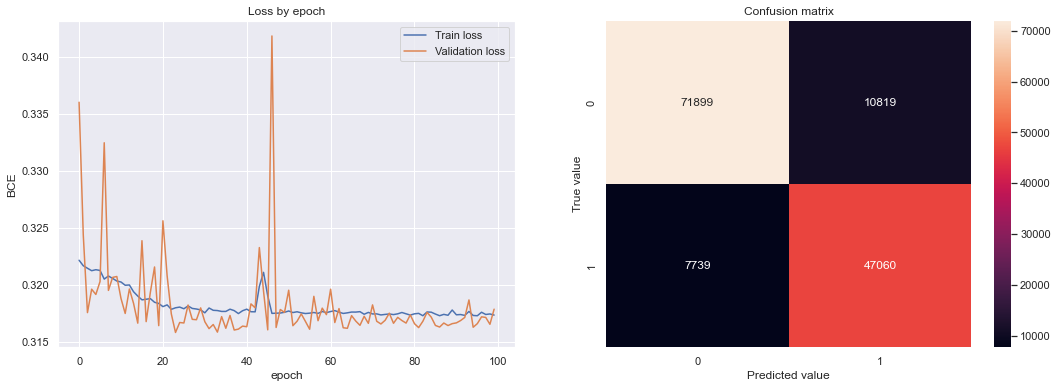

In [400]:
plt.figure(figsize=(18,6))
ax1= plt.subplot(1,2,1)
ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("BCE")
ax2= plt.subplot(1,2,2)
cm = metrics.confusion_matrix(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])
sns.heatmap(cm, annot=True, fmt='g', ax=ax2)
plt.title('Confusion matrix')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.show()